## Evaluation by canal

In [1]:
import os

def make_square(im, min_size=256, fill_color=(0, 0, 0, 255)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    if size == y:
        new_im.paste(im, (int((size - x)/2), 0))
    else:
        new_im.paste(im, (0, int((size - y)/2)))
    return new_im

def resize_images(input_dir, outpur_dir, fill_color='black'):
    images = os.listdir(input_dir)

    for image in images:
        RGBim = Image.open(input_dir + image)
        if fill_color == 'black':
            resized = make_square(RGBim)
        else:
            resized = make_square(RGBim, fill_color=(255,255,255,255))
            
        resized.save(outpur_dir + image.split(".")[0] + ".png", "PNG", quality=100)
        
        if image[-3:] != "png":
            os.remove(input_dir + image)

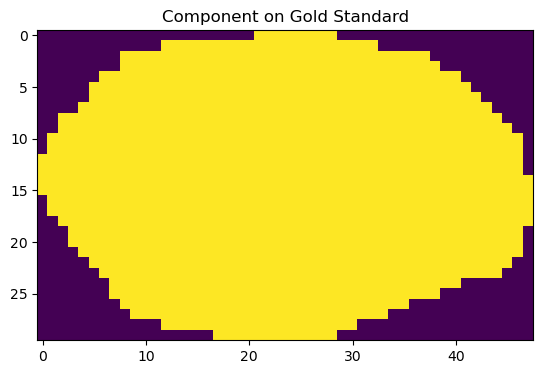

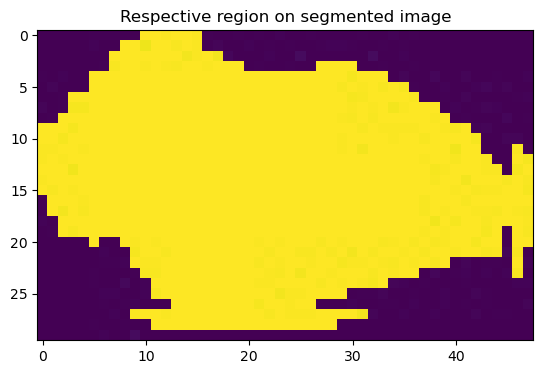

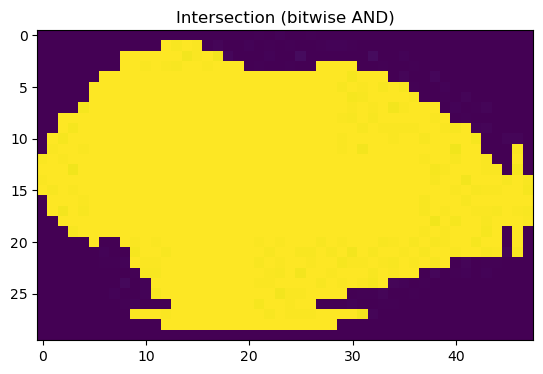

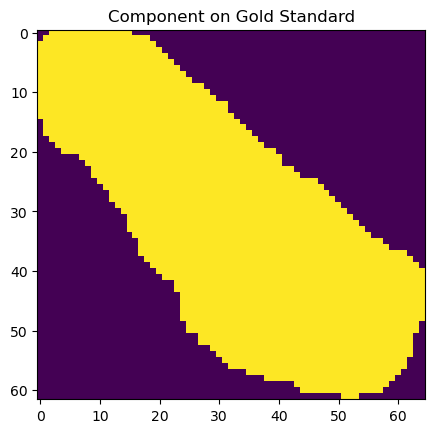

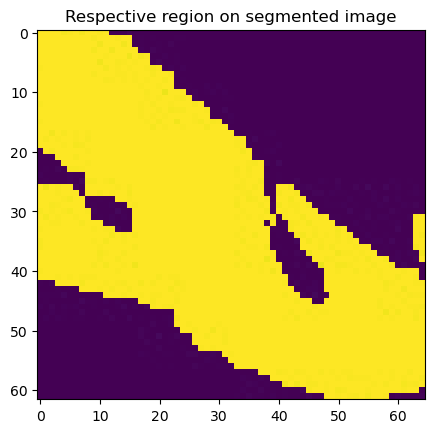

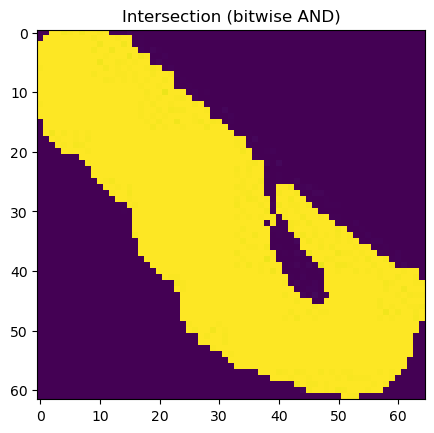

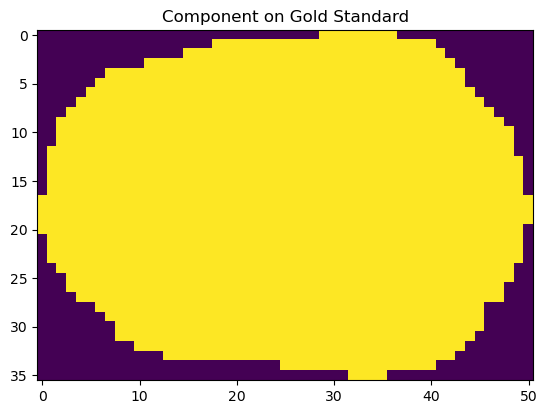

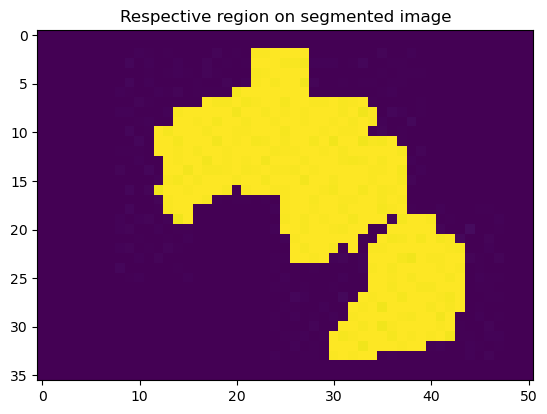

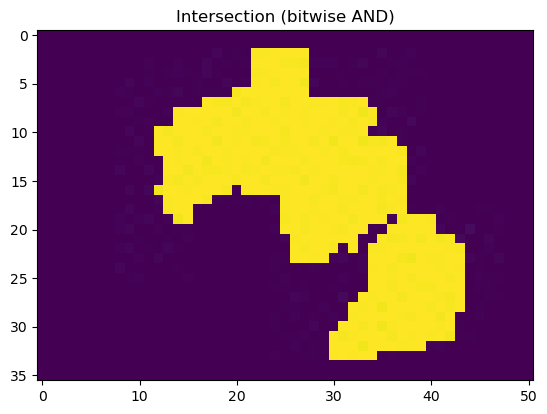

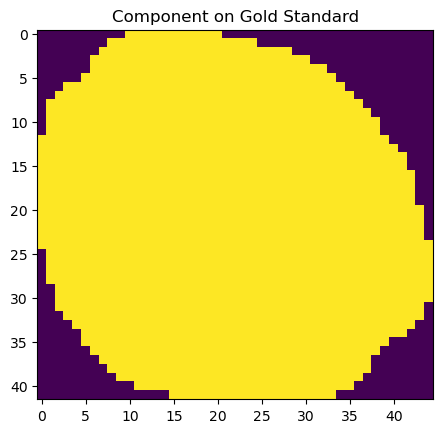

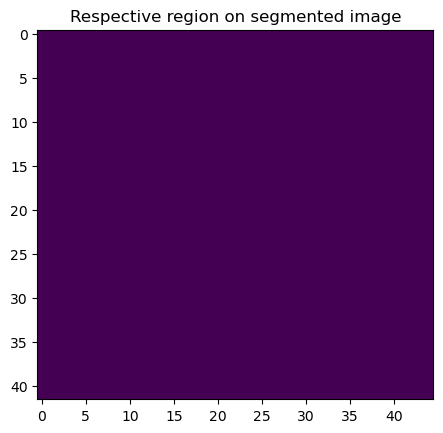

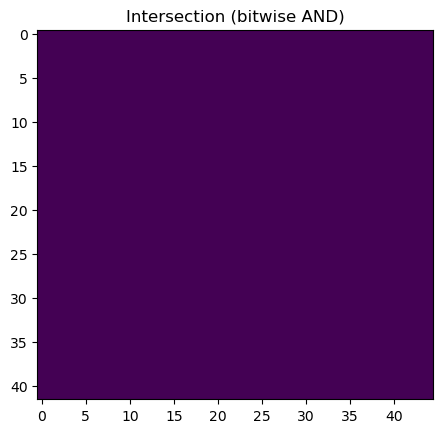

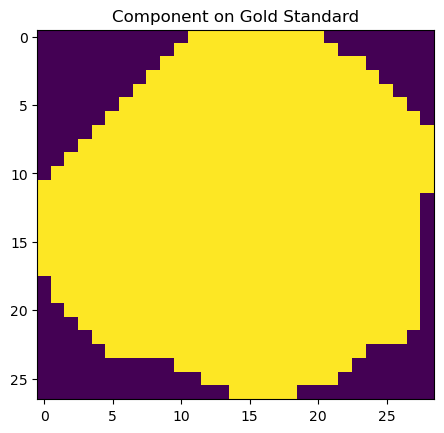

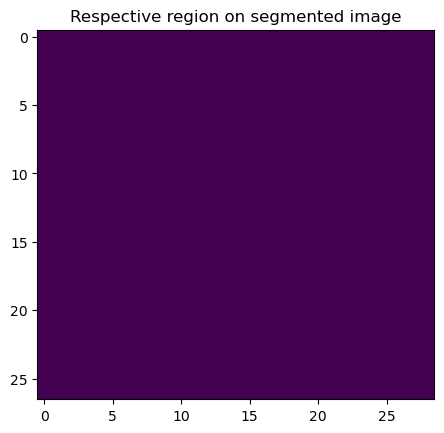

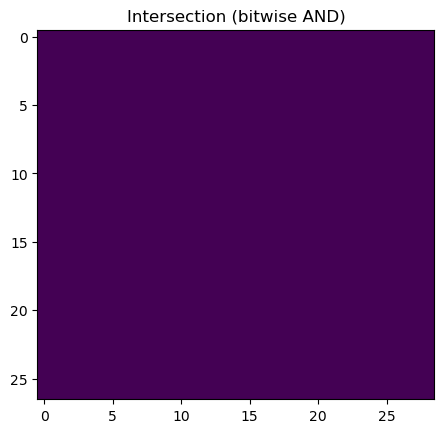

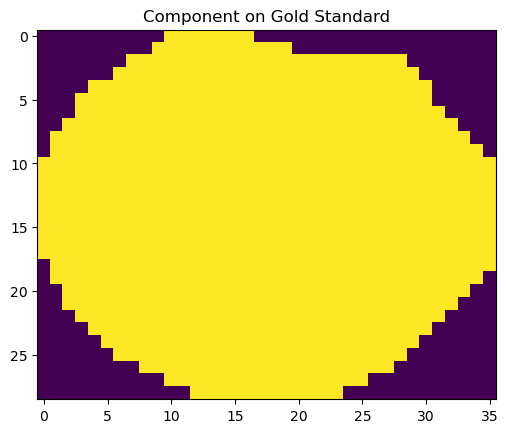

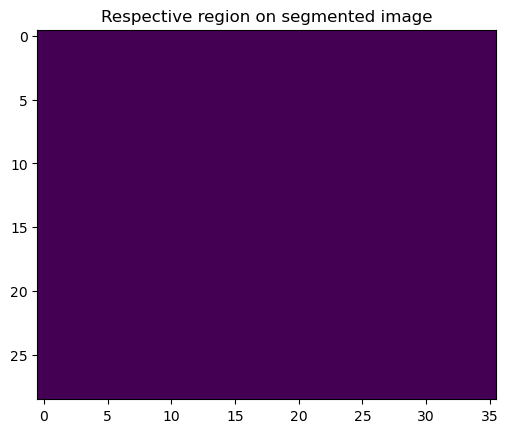

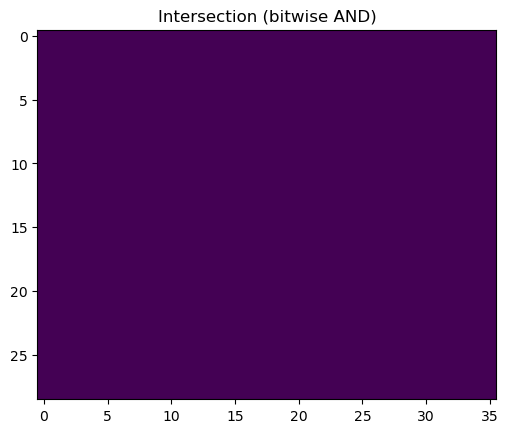

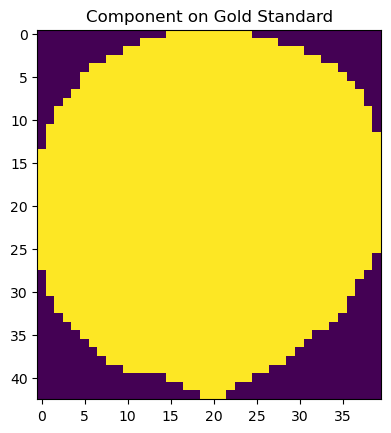

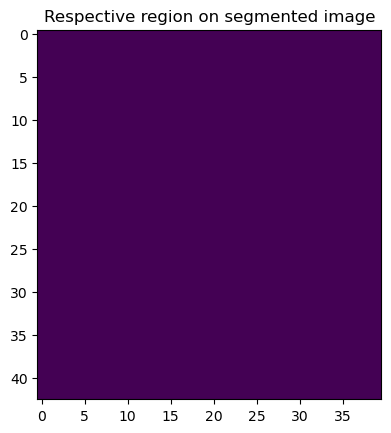

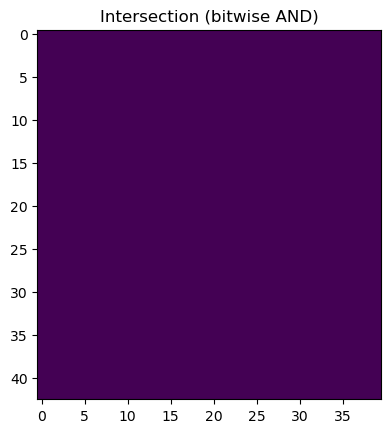

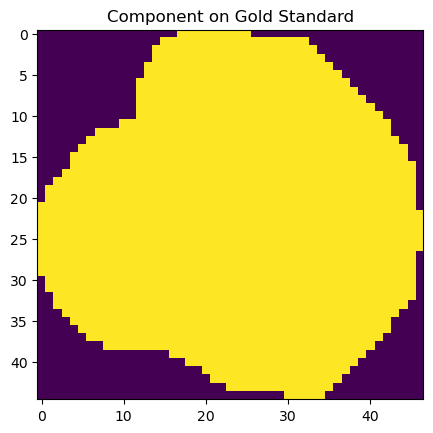

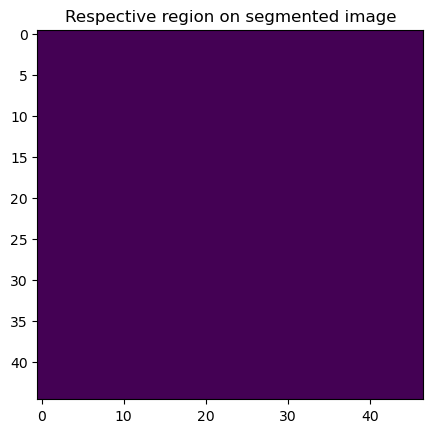

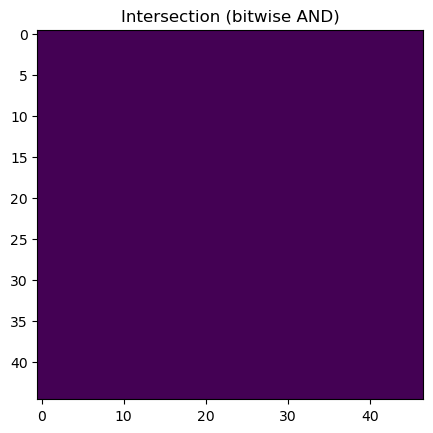

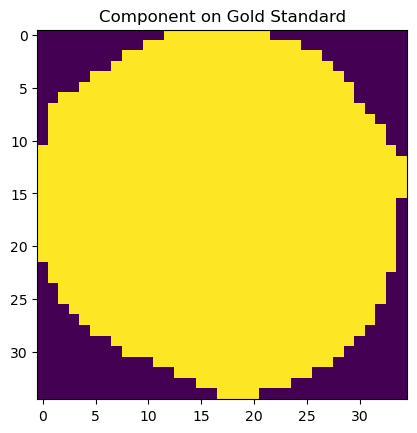

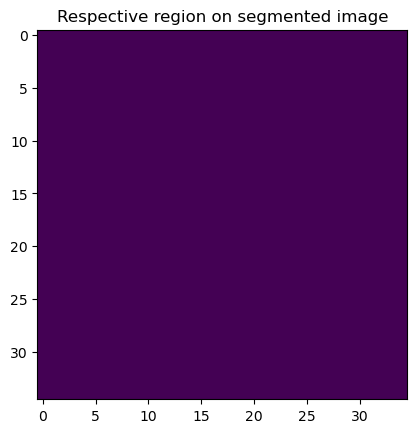

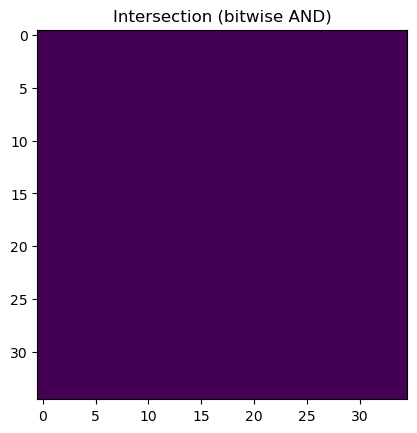

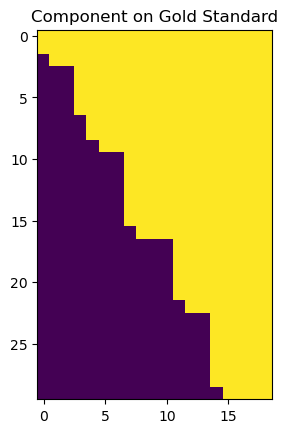

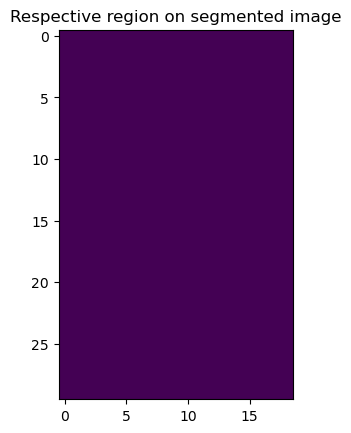

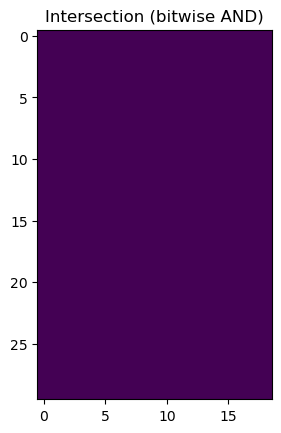

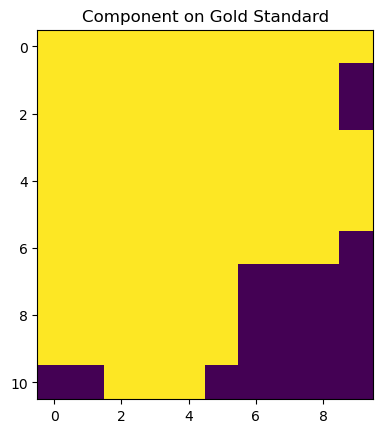

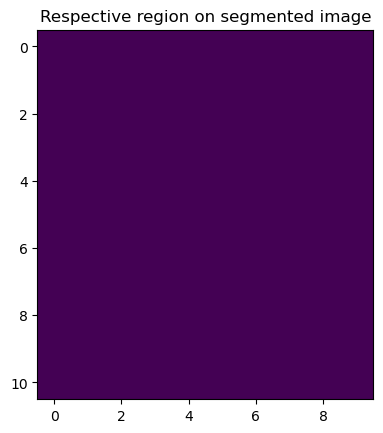

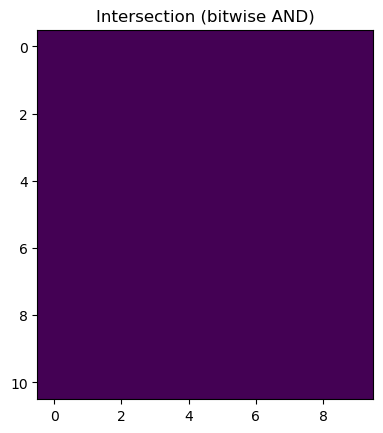

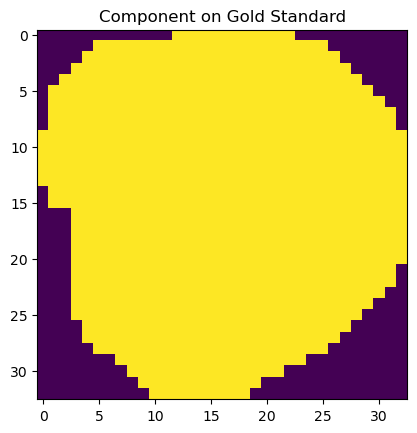

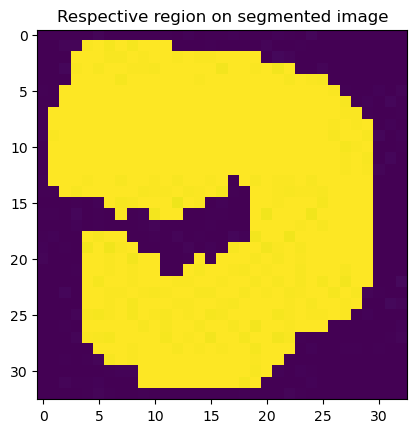

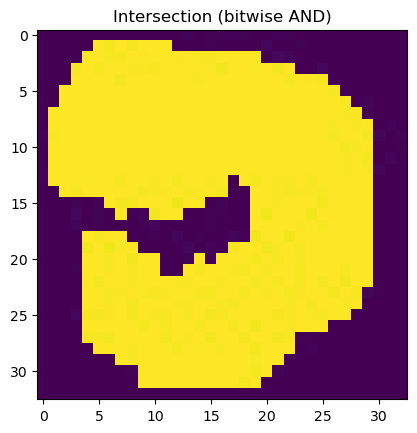

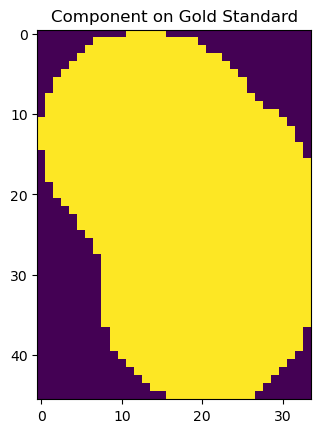

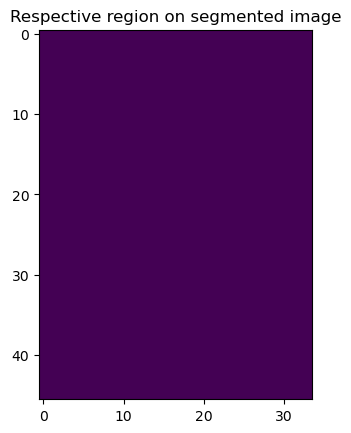

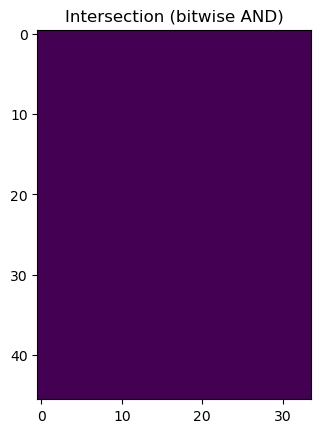

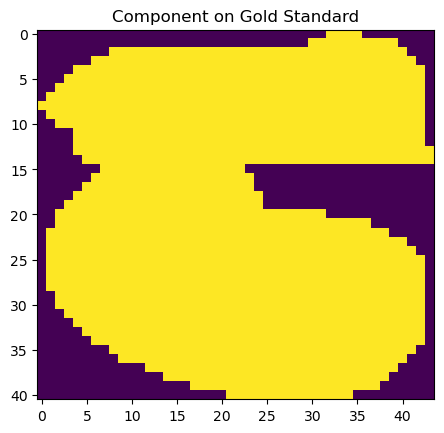

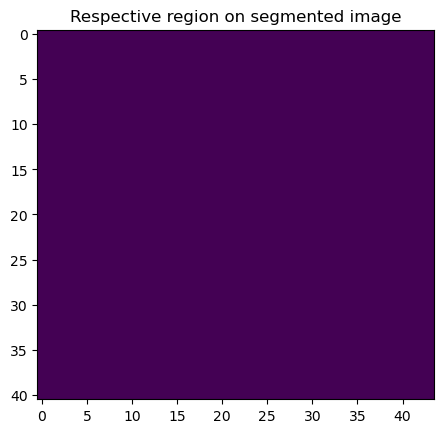

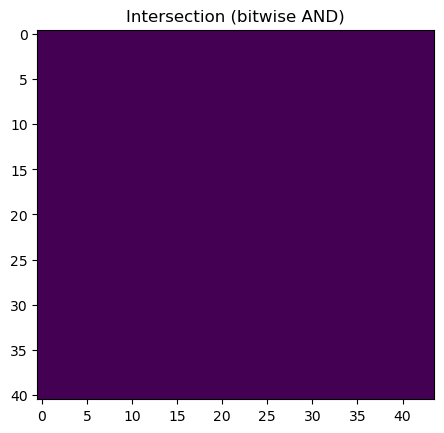

In [5]:
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.measure import regionprops
from PIL import Image 
import numpy as np

percentage_inclusion_threshold = 0.7

segmented_gondim_masks_path = '../../datasets/BONE_CHANNELS/results/gondim/'
resize_images(segmented_gondim_masks_path, segmented_gondim_masks_path)
segmented_gondim_masks = os.listdir(segmented_gondim_masks_path)


original_masks_path = '../../datasets/BONE_CHANNELS/testing/annotations/'

# Verdadeiros positivos (São canais e foram segmentados como canais)
vp = 0
# Verdadeiros negativos (São canais mas não foram segmentados como canais)
vn = 0
# Falsos positivos (Não são canais mas foram segmentados como canais)
fp = 0



for fname in segmented_gondim_masks:
    segmented_mask   = Image.open(segmented_gondim_masks_path + fname)
    original_mask  = Image.open(original_masks_path + fname.split('.')[0] + '.png')

    original_mask_np = np.array(original_mask)[:, :, 0]
    segmented_mask_np = np.array(segmented_mask)[:, :, 0]

    already_processed_components = []
    labeled_original_mask, nr_original_objects = ndimage.label(original_mask_np != 0.)
    original_mask_props = regionprops(labeled_original_mask)

    labeled_segmented_mask, nr_segmented_objects = ndimage.label(segmented_mask_np != 0.)

    for prop_idx in range(len(original_mask_props)):
        ## Calcula verdadeiros positivos e negativos
        [X, Y, x, y] = original_mask_props[prop_idx].bbox  

        bitwised = np.bitwise_and(original_mask_np[X:x, Y:y], segmented_mask_np[X:x, Y:y])

        if prop_idx == 0:
            plt.imshow(original_mask_np[X:x, Y:y])
            plt.title('Component on Gold Standard')
            plt.show()
            plt.title('Respective region on segmented image')
            plt.imshow(segmented_mask_np[X:x, Y:y])
            plt.show()  
            plt.title('Intersection (bitwise AND)')
            plt.imshow(bitwised)
            plt.show()

        count_original = np.count_nonzero(original_mask_np[X:x, Y:y])
        count_intersection = np.count_nonzero(bitwised) 
        percent_included = abs(count_intersection/count_original) 

        if percent_included >= percentage_inclusion_threshold:
            vp = vp + 1

            ## Armazena relações de labels
            bbox_labeled = labeled_original_mask[X:x, Y:y]
            a = np.nonzero(bbox_labeled)[0][0]
            b = np.nonzero(bbox_labeled)[1][0]
            original_mask_label = bbox_labeled[a][b]

            bbox_labeled = labeled_segmented_mask[X:x, Y:y]
            a = np.nonzero(bbox_labeled)[0][0]
            b = np.nonzero(bbox_labeled)[1][0]
            segmented_mask_label = bbox_labeled[a][b]
            already_processed_components.append((original_mask_label, segmented_mask_label))
        else:
            vn = vn + 1
            bbox_labeled = labeled_original_mask[X:x, Y:y]
            a = np.nonzero(bbox_labeled)[0][0]
            b = np.nonzero(bbox_labeled)[1][0]
            original_mask_label = bbox_labeled[a][b]
            already_processed_components.append((original_mask_label, None))

    segmented_mask_props = regionprops(labeled_segmented_mask)

    for prop_idx in range(len(segmented_mask_props)):
        ## Verifica se componente já foi processado
        [X, Y, x, y] = segmented_mask_props[prop_idx].bbox
        bbox_labeled = labeled_segmented_mask[X:x, Y:y]
        a = np.nonzero(bbox_labeled)[0][0]
        b = np.nonzero(bbox_labeled)[1][0]
        current_component_label = bbox_labeled[a][b]
        alread_processed = False

        for i in already_processed_components:
            if i[1] == current_component_label:
                alread_processed = True
                break

        if alread_processed:
            break

        fp = fp + 1
        already_processed_components.append((None, current_component_label))

In [6]:
print('Verdadeiros positivos: ' + str(vp))
print('Verdadeiros negativos: ' + str(vn))
print('Falsos positivos: ' + str(fp))

if vp == 0:
    precision = 0
    recall = 0
    f1 = 0
    accuracy = 0    
else:
    precision = vp/(vp + fp)
    recall = vp/(vp + vn)
    f1 = (2*precision*recall)/(precision + recall)
    accuracy = vp/(vp + vn + fp)

print('Acurácia: ' + str(accuracy))
print('Sensibilidade: ' + str(recall))
print('Precisão: ' + str(precision))
print('F1-Score: ' + str(f1))

Verdadeiros positivos: 391
Verdadeiros negativos: 3447
Falsos positivos: 241
Acurácia: 0.09585682765383673
Sensibilidade: 0.10187597707139134
Precisão: 0.6186708860759493
F1-Score: 0.1749440715883669
